In [1]:
#! unzip drive/MyDrive/FER_2013.zip

In [2]:
# importing libraries
import keras
import pandas
import numpy
import matplotlib.pyplot as plt
import cv2

In [3]:
from google.colab import output
import time

In [4]:
# importing MobileNetV2
model = keras.applications.MobileNetV2(include_top=False,
                                       weights='imagenet',
                                       input_shape=(48,48,3),
                                       classifier_activation="softmax")


In [5]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [6]:
# adding the layers to finetune
finetuned_model = keras.Sequential()
finetuned_model.add(model)
finetuned_model.add(keras.layers.GlobalAveragePooling2D())
finetuned_model.add(keras.layers.Dense(7, activation='softmax'))

In [7]:
finetuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


In [8]:
# adding learning rate decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=100000,
    decay_rate=0.9)

In [9]:
# creating an ImageDataGenerator object
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=.2)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
# creating a callback to the best model
checkpointer = keras.callbacks.ModelCheckpoint(monitor = "val_accuracy",filepath='best_emo_no_stop_model.hdf5', 
                                               save_best_only=True,verbose = 1)

# adding early stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                                mode = "max",verbose = 0,
#                                                patience=20)
call_backs = [checkpointer]

In [11]:
CLASS_NAMES = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [12]:
# creating train/validation generator

train_generator = train_datagen.flow_from_directory(
    "data/train",
    batch_size=64,
    target_size=(150, 150),
    classes = list(CLASS_NAMES),
    seed=1,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    "data/train",
    batch_size=64,
    target_size=(150, 150),
    seed=1,
    class_mode='categorical',
    subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [13]:
train_generator.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [14]:
finetuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), 
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [15]:
# training
history = finetuned_model.fit(train_generator
                              , epochs=300
                              , validation_data=val_generator
                              , validation_steps=90
                              , steps_per_epoch=359
                              , callbacks=call_backs)

In [19]:
finetuned_model.save_weights("drive/MyDrive/current_emo_no_stop_model.hdf5")

In [20]:
! cp best_emo_no_stop_model.hdf5 drive/MyDrive/

In [18]:

for i in range(30):
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    time.sleep(1)

KeyboardInterrupt: ignored

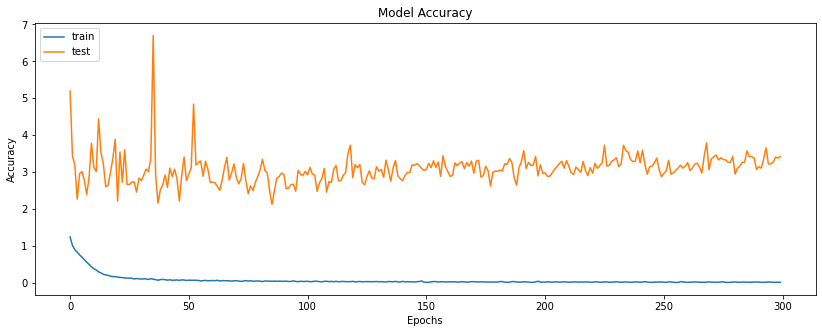

In [21]:
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

In [22]:
test_generator = test_datagen.flow_from_directory(
    "data/test",
    batch_size=64,
    target_size=(150, 150),
    classes = list(CLASS_NAMES),
    seed=1,
    class_mode='categorical',
    subset='training')

Found 7178 images belonging to 7 classes.


In [23]:
finetuned_model.evaluate(train_generator,batch_size=64)

359/359 [==============================] - 21s 58ms/step - loss: 0.0195 - accuracy: 0.9939


[0.01945335417985916, 0.9939481019973755]

In [24]:
finetuned_model.evaluate(val_generator,batch_size=64)

90/90 [==============================] - 5s 58ms/step - loss: 3.4174 - accuracy: 0.6422


[3.4174067974090576, 0.6422225832939148]

In [25]:
finetuned_model.evaluate(test_generator,batch_size=64)

113/113 [==============================] - 7s 59ms/step - loss: 3.4065 - accuracy: 0.6499


[3.406506299972534, 0.6499024629592896]

In [26]:
import pickle
pickle.dump({"loss":history.history['loss'],
             "val_loss":history.history['val_loss'],
             "acc":history.history['accuracy'],
             "val_acc":history.history['val_accuracy']},open("history.p","wb"))

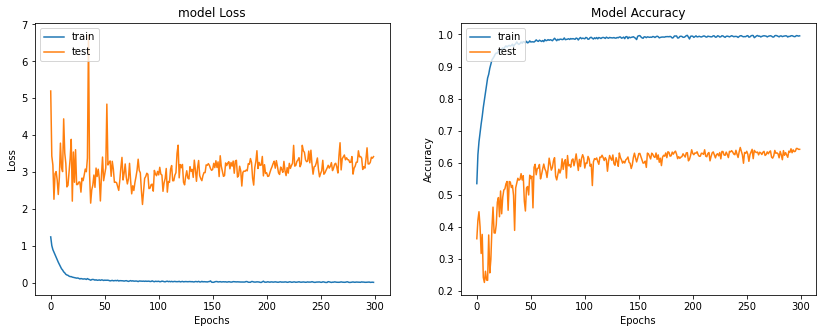

In [27]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
finetuned_model.load_weights("best_emo_no_stop_model.hdf5")

In [33]:
import numpy as np

Confusion Matrix
[[ 459   51  463  799  539  509  376]
 [  45    5   51   95   49   61   43]
 [ 459   44  447  845  567  560  356]
 [ 777   91  837 1444 1012  993  618]
 [ 524   56  557 1025  704  664  442]
 [ 558   61  528  979  662  636  440]
 [ 357   38  347  628  474  409  284]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
   disgusted       0.01      0.01      0.01       349
     fearful       0.14      0.14      0.14      3278
       happy       0.25      0.25      0.25      5772
     neutral       0.18      0.18      0.18      3972
         sad       0.17      0.16      0.17      3864
   surprised       0.11      0.11      0.11      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



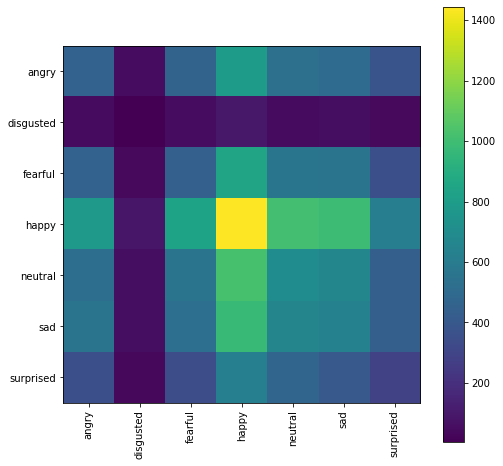

In [34]:
y_pred = finetuned_model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[110   9  97 274 192 158 118]
 [ 17   0  14  33  17  15  15]
 [112  12 120 284 210 155 131]
 [204  16 195 514 353 265 227]
 [147  17 117 347 244 202 159]
 [150  10 137 333 242 220 155]
 [101  14  88 231 175 117 105]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.16      0.12      0.13      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.19      0.18      0.18      1247
   surprised       0.12      0.13      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



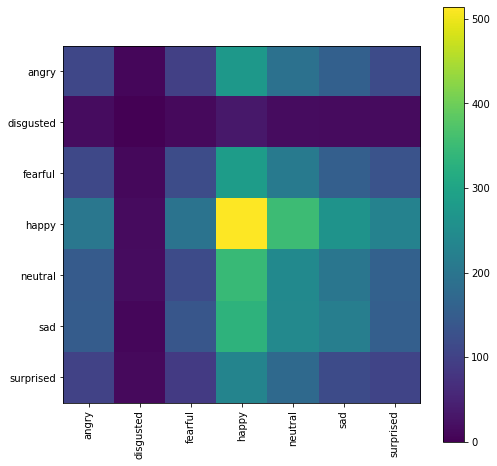

In [35]:
y_pred = finetuned_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [36]:
# saving model hyperparameters
config = finetuned_model.get_config()
pickle.dump(config,open("drive/MyDrive/model.p","wb"))

In [37]:
finetuned_model.evaluate(train_generator)

359/359 [==============================] - 21s 59ms/step - loss: 0.0266 - accuracy: 0.9913


[0.026619283482432365, 0.9913357496261597]

In [38]:
finetuned_model.evaluate(val_generator)

90/90 [==============================] - 5s 58ms/step - loss: 3.1414 - accuracy: 0.6480


[3.141389846801758, 0.6479707360267639]

In [39]:
finetuned_model.evaluate(test_generator)

113/113 [==============================] - 7s 59ms/step - loss: 3.1676 - accuracy: 0.6408


[3.1676065921783447, 0.6408470273017883]